## Import libraries

In [1]:
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seaborn is a data visualization library built on matplotlib
import seaborn as sns
# set the plotting style
sns.set_style("whitegrid")

# Model preprocessing
from sklearn.preprocessing import StandardScaler\

# Modeling
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

## Load the data

##### Load the EdGap data set - you will need to download the file from github and load them from your local drive
Github url - https://github.com/alexsong-lab/DATA5100/tree/main/education/data

In [2]:
edgap = pd.read_excel(
    r"C:\Users\alexm\OneDrive - Seattle University\5100 Project\DATA5100\education\data\EdGap_data.xlsx",
    engine="openpyxl"
)

C:\Users\alexm\OneDrive - Seattle University\5100 Project\DATA5100\.venv\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


##### Load the school information data in pandas

In [3]:
school_information = pd.read_csv(
    r"C:\Users\alexm\OneDrive - Seattle University\5100 Project\DATA5100\education\data\ccd_sch_029_1617_w_1a_11212017.csv",
    encoding="unicode_escape",
    low_memory=False
)

In [4]:
school_funding = pd.read_excel(
    r"C:\Users\alexm\OneDrive - Seattle University\5100 Project\DATA5100\education\data\elsec17t.xls",
    engine="xlrd"
)

In [5]:
school_funding.head(3)

,IDCENSUS,NAME,CONUM,CSA,CBSA,NCESID,ENROLL,TOTALREV,TFEDREV,FEDRCOMP,...,PPSALWG,PPEMPBEN,PPITOTAL,PPISALWG,PPIEMBEN,PPSTOTAL,PPSPUPIL,PPSSTAFF,PPSGENAD,PPSSCHAD
0,1500100100000,AUTAUGA COUNTY SCHOOL DISTRICT,1001,N,33860,0100240,9307,82619,7167,1778,...,4768,2004,4906,3252,1274,2654,432,210,188,512
1,1500200100000,BALDWIN COUNTY SCHOOL DISTRICT,1003,380,19300,0100270,31268,363148,24673,6769,...,5231,2076,5312,3457,1325,3280,596,361,123,604
2,1500300100000,BARBOUR COUNTY SCHOOL DISTRICT,1005,N,21640,0100300,847,10628,2140,1057,...,6194,2469,5968,3659,1388,4664,540,425,780,740


## Select relevant subsets of the data
Rename abbreviations to easy-to-understand names

In [6]:
school_information = school_information[
    ['SCHOOL_YEAR', 'NCESSCH', 'LEAID', 'LSTATE', 'LZIP', 'SCH_TYPE_TEXT', 'LEVEL', 'CHARTER_TEXT']
]

In [7]:
school_funding = school_funding[
    [
        "NCESID",  #same as the LEAID in school information dataset
        "PPCSTOT",
        "PPSALWG",
        "PPEMPBEN",
        "PPITOTAL",
        "PPISALWG",
        "PPIEMBEN",
        "PPSPUPIL"
    ]
]

In [8]:
school_funding = school_funding.rename(
    columns={
    "NCESID": "L_id",
    "PPCSTOT": "PerPupil_Total_Expenditure",
    "PPSALWG": "PerPupil_Salary_Expenditure",
    "PPEMPBEN": "PerPupil_Benefits_Expenditure",
    "PPITOTAL": "PerInstructor_Total_Expenditure",
    "PPISALWG": "PerInstructor_Salary",
    "PPIEMBEN": "PerInstructor_Benefits",
    "PPSPUPIL": "PerPupil_StudentSupport_Expenditure"
    }
)

In [9]:
edgap = edgap.rename(
    columns={
        "NCESSCH School ID": "id",
        "CT Pct Adults with College Degree": "percent_college",
        "CT Unemployment Rate": "rate_unemployment",
        "CT Pct Childre In Married Couple Family": "percent_married",
        "CT Median Household Income": "median_income",
        "School ACT average (or equivalent if SAT score)": "average_act",
        "School Pct Free and Reduced Lunch": "percent_lunch",
    }
)

In [10]:
school_information = school_information.rename(
    columns={
        "SCHOOL_YEAR": "year",
        "NCESSCH": "id",
        "LEAID": "L_id",
        "LSTATE": "state",
        "LZIP": "zip_code",
        "SCH_TYPE_TEXT": "school_type",
        "LEVEL": "school_level",
        "CHARTER_TEXT": "charter"
    }
)

##### Checking columns are renamed

In [11]:
edgap.head(1)

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901


In [12]:
school_funding.head(1)

,L_id,PerPupil_Total_Expenditure,PerPupil_Salary_Expenditure,PerPupil_Benefits_Expenditure,PerInstructor_Total_Expenditure,PerInstructor_Salary,PerInstructor_Benefits,PerPupil_StudentSupport_Expenditure
0,0100240,8119,4768,2004,4906,3252,1274,432


In [13]:
school_information.head(1)

,year,id,L_id,state,zip_code,school_type,school_level,charter
0,2016-2017,1.000020e+10,0100002,AL,35220,Alternative School,High,No


# Join data frames

##### Join the data frames and call the result `df`.
Join school info and funding by using LEAID, and then merge with Edgap using the school id

In [14]:
# join school_information & school_funding
merged_info_funding = school_information.merge(school_funding, how='left', on="L_id")

# join the merged data set to edgap data
df = edgap.merge(merged_info_funding, how='left', on="id")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   7986 non-null   int64  
 1   rate_unemployment                    7972 non-null   float64
 2   percent_college                      7973 non-null   float64
 3   percent_married                      7961 non-null   float64
 4   median_income                        7966 non-null   float64
 5   average_act                          7986 non-null   float64
 6   percent_lunch                        7986 non-null   float64
 7   year                                 7898 non-null   object 
 8   L_id                                 7898 non-null   object 
 9   state                                7898 non-null   object 
 10  zip_code                             7898 non-null   object 
 11  school_type                   

# Quality Control

In [16]:
df.describe()

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,PerPupil_Total_Expenditure,PerPupil_Salary_Expenditure,PerPupil_Benefits_Expenditure,PerInstructor_Total_Expenditure,PerInstructor_Salary,PerInstructor_Benefits,PerPupil_StudentSupport_Expenditure
count,7.986000e+03,7972.000000,7973.000000,7961.000000,7966.000000,7986.000000,7986.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000
mean,3.321869e+11,0.098730,0.568930,0.633440,52026.905222,20.181532,0.420651,11603.118351,6573.194639,2875.387491,6958.568797,4411.237526,1917.979794,665.206048
std,1.323638e+11,0.058959,0.165704,0.196764,24228.057079,2.595201,0.239754,3364.692052,1802.748922,1511.669687,2001.270790,1189.291860,1023.264500,468.103641
min,1.000016e+11,0.000000,0.091493,0.000000,3589.000000,-3.070818,-0.054545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.105340e+11,0.058655,0.450828,0.523810,36597.250000,18.600000,0.238501,9318.000000,5447.000000,1841.000000,5626.000000,3664.000000,1210.500000,394.000000
50%,3.600085e+11,0.085649,0.554979,0.667594,46833.500000,20.400000,0.381570,10549.000000,6097.000000,2582.000000,6271.000000,4112.000000,1666.000000,528.000000
75%,4.226678e+11,0.123376,0.676571,0.777135,61369.250000,21.910867,0.575447,12896.000000,6998.500000,3607.000000,7650.500000,4726.500000,2471.000000,741.000000
max,5.605830e+11,0.590278,1.000000,1.000000,226181.000000,32.362637,0.998729,45586.000000,19753.000000,16373.000000,19437.000000,13291.000000,8787.000000,5863.000000


In [17]:
df.select_dtypes(include=['number']).agg(['min', 'max']).round(2)

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,PerPupil_Total_Expenditure,PerPupil_Salary_Expenditure,PerPupil_Benefits_Expenditure,PerInstructor_Total_Expenditure,PerInstructor_Salary,PerInstructor_Benefits,PerPupil_StudentSupport_Expenditure
min,100001600143,0.00,0.09,0.0,3589.0,-3.07,-0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,560583000335,0.59,1.00,1.0,226181.0,32.36,1.00,45586.0,19753.0,16373.0,19437.0,13291.0,8787.0,5863.0


##### Set out-of-range values to `NaN` using `np.nan`.
no out of range values found in school_funding dataset

In [18]:
df.loc[df['percent_lunch'] < 0, 'percent_lunch'] = np.nan

In [19]:
df.loc[df['average_act'] < 1, 'average_act'] = np.nan

##### Keep only the high schools.

In [20]:
df = df.loc[df['school_level'] == 'High']

##### Check for any duplicated rows

In [21]:
df.duplicated().sum()

np.int64(0)

## Identify missing values

##### What percentage of values of each variable are missing?
missing values: highest 5.46%, zero values: highest .65%

In [22]:
# Percentage of missing values per column
percent_missing = df.isna().mean().round(4) * 100
percent_missing.to_frame(name='Percent Missing Values')


,Percent Missing Values
id,0.00
rate_unemployment,0.17
percent_college,0.15
percent_married,0.28
median_income,0.22
average_act,0.04
percent_lunch,0.28
year,0.00
L_id,0.00
state,0.00


In [23]:
# Percentage of zeros per column
percent_zeros = (df == 0).mean().round(4) * 100
percent_zeros.to_frame(name='Percent Zeros')

,Percent Zeros
id,0.00
rate_unemployment,0.14
percent_college,0.00
percent_married,0.19
median_income,0.00
average_act,0.00
percent_lunch,0.65
year,0.00
L_id,0.00
state,0.00


##### What states do we have data from?

In [24]:
df['state'].value_counts()

state
TX    913
OH    654
IL    564
PA    543
MI    498
NC    407
FL    404
GA    367
WI    351
NJ    341
MO    337
IN    321
NY    295
TN    265
WA    263
MA    253
KY    198
LA    194
WY     38
DE     24
Name: count, dtype: int64

In [25]:
df['state'].nunique()

20

##### Plot the results on a map

In [26]:
import plotly.offline as po
import plotly.graph_objs as pg

In [27]:
layout = dict(
    geo={"scope": "usa"}, coloraxis_colorbar=dict(title="Number of Schools")
)

data = dict(
    type="choropleth",
    locations=df["state"].value_counts().index,
    locationmode="USA-states",
    z=df["state"].value_counts().values,
    coloraxis="coloraxis",
)

x = pg.Figure(data=[data], layout=layout)

po.iplot(x)

##### Drop the rows where the average ACT score is missing

In [28]:
df = df.dropna(subset=['average_act'])

In [29]:
df.isna().sum().to_frame(name='Number of Missing Values')

,Number of Missing Values
id,0
rate_unemployment,12
percent_college,11
percent_married,20
median_income,16
average_act,0
percent_lunch,20
year,0
L_id,0
state,0


##### If we drop rows that have `NaNs` for any school funding variables, then we will negatively affect our analysis using the variables where data were present. So, we will not drop the rows in this data set that are missing the school funding variables. We will impute the missing values.

# Data imputation

In [30]:
predictor_variables = [
    'rate_unemployment',
    'percent_college',
    'percent_married',
    'median_income',
    'percent_lunch',
    'state',
    'charter',
    'PerPupil_Total_Expenditure',
    'PerPupil_Salary_Expenditure',
    'PerPupil_Benefits_Expenditure',
    'PerInstructor_Salary',
    'PerInstructor_Benefits',
    'PerPupil_StudentSupport_Expenditure'
]

In [31]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [32]:
imputer = IterativeImputer()

In [33]:
numerical_predictors = df[predictor_variables].select_dtypes(include='number').columns.to_list()

print(numerical_predictors)

['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'percent_lunch', 'PerPupil_Total_Expenditure', 'PerPupil_Salary_Expenditure', 'PerPupil_Benefits_Expenditure', 'PerInstructor_Salary', 'PerInstructor_Benefits', 'PerPupil_StudentSupport_Expenditure']


##### Fit the imputer

In [34]:
imputer.fit(df.loc[:, numerical_predictors])

C:\Users\alexm\OneDrive - Seattle University\5100 Project\DATA5100\.venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



,estimator,None
,missing_values,nan
,sample_posterior,False
,max_iter,10
,tol,0.001
,n_nearest_features,None
,initial_strategy,'mean'
,fill_value,None
,imputation_order,'ascending'
,skip_complete,False
,min_value,-inf


##### Impute the missing values in the training data.

In [35]:
df.loc[:, numerical_predictors] = imputer.transform(df.loc[:, numerical_predictors])

##### Check for missing values

In [36]:
df.isna().sum().to_frame(name='Number of Missing Values')


,Number of Missing Values
id,0
rate_unemployment,0
percent_college,0
percent_married,0
median_income,0
average_act,0
percent_lunch,0
year,0
L_id,0
state,0


###### Export the clean data set

In [37]:
df.to_csv(
    'education_clean.csv',
    encoding='utf-8-sig',
    index=False
)

##### Use the iterative imputer to replace missing values in the columns corresponding to predictor variables in the analysis.

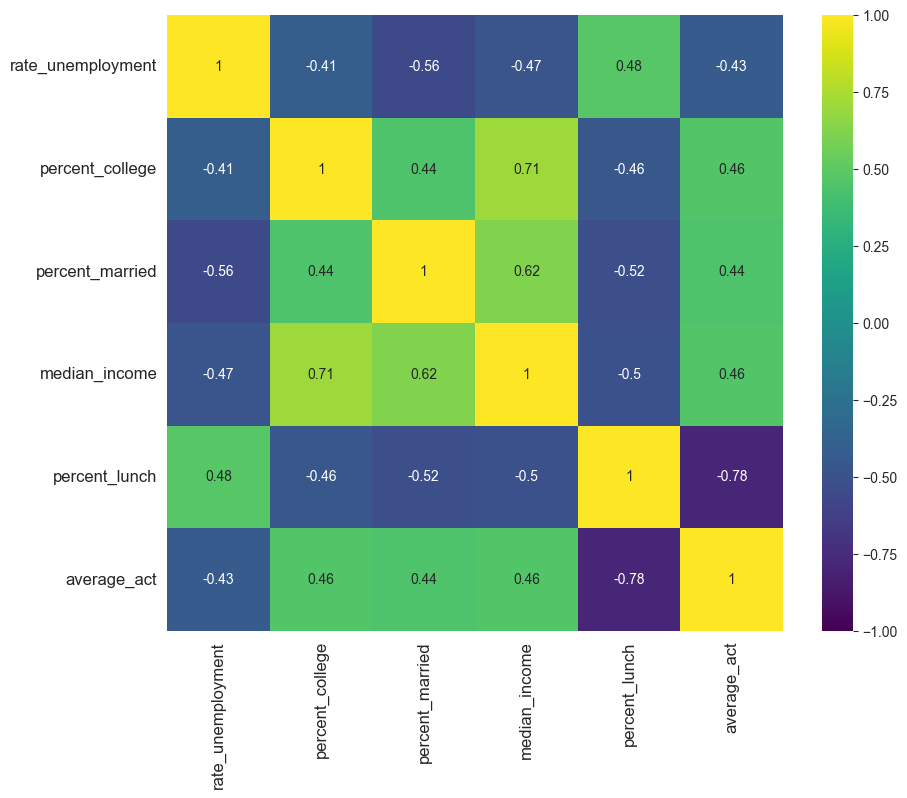

In [38]:
predictor_variables = ['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'percent_lunch', 'state', 'charter']

numerical_predictors = df[predictor_variables].select_dtypes(include='number').columns.to_list()

corr_matrix = df[numerical_predictors + ["average_act"]].corr()

plt.figure(figsize = (10, 8))

sns.heatmap(
    corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap="viridis"
)

plt.tick_params(labelsize=12)

plt.show()

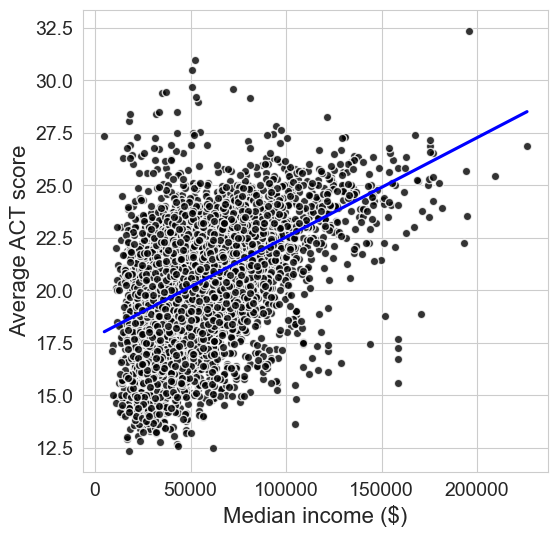

In [39]:
plt.figure(figsize=(6, 6))

sns.regplot(data=df,
            x='median_income',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('Median income ($)', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

In [40]:
model_median_income = smf.ols(formula='average_act ~ median_income', data=df).fit()

In [41]:
print(model_median_income.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     1933.
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        10:40:28   Log-Likelihood:                -16044.
No. Observations:                7227   AIC:                         3.209e+04
Df Residuals:                    7225   BIC:                         3.211e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.8003      0.063    284.469

In [42]:
model_median_income.rsquared

np.float64(0.21108864397829974)

In [43]:
y_hat = model_median_income.predict()

In [44]:
np.sqrt(mean_squared_error(df['average_act'], y_hat)).round(3)

np.float64(2.228)

In [45]:
mean_absolute_error(df['average_act'], y_hat)

1.7131346593502226

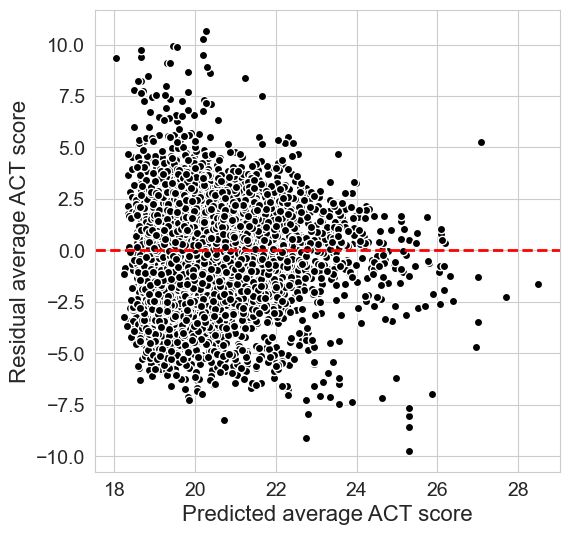

In [46]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat, model_median_income.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

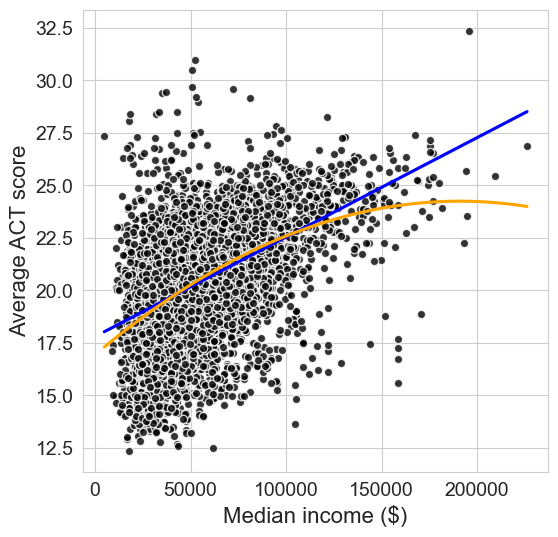

In [47]:
plt.figure(figsize=(6, 6))

sns.regplot(data=df,
            x='median_income',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

sns.regplot(data=df,
            x='median_income',
            y='average_act',
            order=2,
            color='orange',
            ci=False,
            scatter=False)

# Add axis labels
plt.xlabel('Median income ($)', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

In [48]:
model_median_income2 = smf.ols(
    formula='average_act ~ median_income + I(median_income**2)',
    data=df).fit()

In [49]:
model_median_income2.pvalues

Intercept                0.000000e+00
median_income            1.726911e-99
I(median_income ** 2)    9.184645e-18
dtype: float64

In [50]:
mean_absolute_error(df['average_act'], model_median_income2.predict())

1.6972381038939799

In [51]:
mean_absolute_error(df['average_act'], model_median_income.predict())

1.7131346593502226

## Miltiple linear regression

In [52]:
model = smf.ols(
    formula='average_act ~ rate_unemployment + percent_college + percent_married + median_income + percent_lunch',
    data=df).fit()

In [53]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     2441.
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        10:40:29   Log-Likelihood:                -13325.
No. Observations:                7227   AIC:                         2.666e+04
Df Residuals:                    7221   BIC:                         2.670e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6946      0.13

In [54]:
y_hat = model.predict()

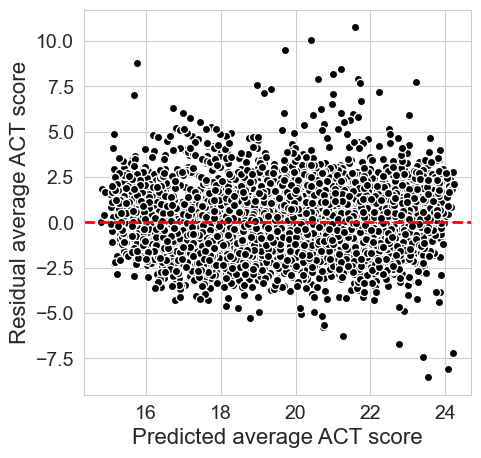

In [55]:
plt.figure(figsize=(5, 5))

plt.plot(y_hat, model.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16) #this must be the predicted act score since we no longer hange a sing plot, rather have the multiple points68
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

In [56]:
mean_absolute_error(df['average_act'], model.predict())

1.145195458449783

## Reduced Model

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     4069.
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        10:40:29   Log-Likelihood:                -13325.
No. Observations:                7227   AIC:                         2.666e+04
Df Residuals:                    7223   BIC:                         2.669e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6398      0.10

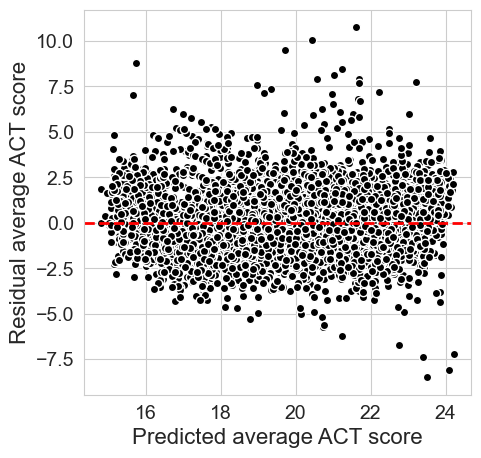

In [57]:
model_reduced = smf.ols(
    formula='average_act ~ rate_unemployment + percent_college + percent_lunch',
    data=df).fit()

print(model_reduced.summary())

y_hat = model_reduced.predict()
plt.figure(figsize=(5, 5))

plt.plot(y_hat, model_reduced.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

In [58]:
mean_absolute_error(df['average_act'], model_reduced.predict())

1.145321909266975

In [59]:
mae_full = mean_absolute_error(df['average_act'], model.predict())
mae_reduced = mean_absolute_error(df['average_act'], model_reduced.predict())

r2_full = model.rsquared
r2_reduced = model_reduced.rsquared

pd.DataFrame({'Mean Absolute Error': [mae_full, mae_reduced],
              'R-squared': [r2_full, r2_reduced]},
              index=['full model', 'reduced model']).round(4)

,Mean Absolute Error,R-squared
full model,1.1452,0.6283
reduced model,1.1453,0.6282


In [60]:
model_charter = smf.ols(
    formula='average_act ~ rate_unemployment + percent_college + percent_lunch + C(charter)',
    data=df).fit()

In [61]:
print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     4069.
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        10:40:29   Log-Likelihood:                -13325.
No. Observations:                7227   AIC:                         2.666e+04
Df Residuals:                    7223   BIC:                         2.669e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6398      0.10

In [62]:
predictor_variables = ['rate_unemployment', 'percent_college', 'percent_lunch']

In [63]:
scaled_columns = [var + '_normalized' for var in predictor_variables]
print(scaled_columns)

['rate_unemployment_normalized', 'percent_college_normalized', 'percent_lunch_normalized']


In [64]:
scaler = StandardScaler().fit(df[predictor_variables])

In [65]:
df[scaled_columns] = scaler.transform(df[predictor_variables])

In [66]:
df[scaled_columns].agg(['mean', 'std']).round(3)

,rate_unemployment_normalized,percent_college_normalized,percent_lunch_normalized
mean,0.0,-0.0,-0.0
std,1.0,1.0,1.0


In [67]:
model_normalized = smf.ols(
  formula='average_act ~ rate_unemployment_normalized + percent_college_normalized + percent_lunch_normalized',
    data=df).fit()

In [68]:
print(model_normalized.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     4069.
Date:                Thu, 23 Oct 2025   Prob (F-statistic):               0.00
Time:                        10:40:29   Log-Likelihood:                -13325.
No. Observations:                7227   AIC:                         2.666e+04
Df Residuals:                    7223   BIC:                         2.669e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [69]:
mae_normalized = mean_absolute_error(df['average_act'], model_normalized.predict())
mae_reduced = mean_absolute_error(df['average_act'], model_reduced.predict())

r2_normalized = model_normalized.rsquared
r2_reduced = model_reduced.rsquared

pd.DataFrame({'Mean Absolute Error': [mae_normalized, mae_reduced],
              'R-squared': [r2_normalized, r2_reduced]},
             index=['normalized model', 'reduced model']).round(4)

,Mean Absolute Error,R-squared
normalized model,1.1453,0.6282
reduced model,1.1453,0.6282


## Per Pupil Total Expenditure vs. ACT Score
This analysis tests whether higher per-pupil total expenditure is associated with higher ACT scores.

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     29.81
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           4.94e-08
Time:                        10:40:29   Log-Likelihood:                -16886.
No. Observations:                7227   AIC:                         3.378e+04
Df Residuals:                    7225   BIC:                         3.379e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

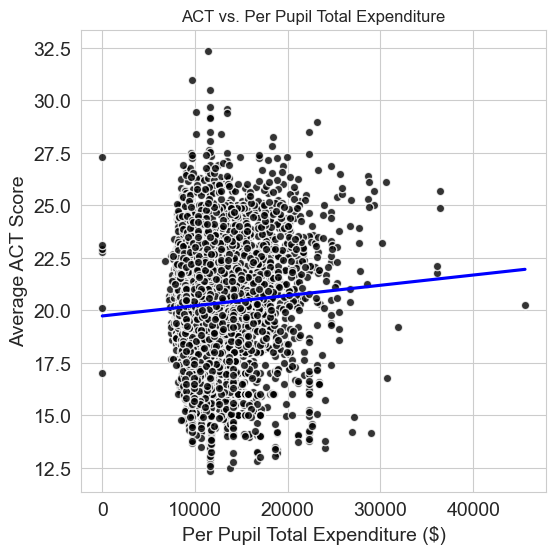

In [70]:
model = smf.ols(
    formula='average_act ~ PerPupil_Total_Expenditure',
    data=df
).fit()

print(model.summary())

print(model.summary())
plt.figure(figsize=(6, 6))

sns.regplot(data=df,
            x='PerPupil_Total_Expenditure',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# the tick labels
plt.tick_params(labelsize=14)

plt.xlabel('Per Pupil Total Expenditure ($)', fontsize=14)
plt.ylabel('Average ACT Score', fontsize=14)
plt.title('ACT vs. Per Pupil Total Expenditure')
plt.show()

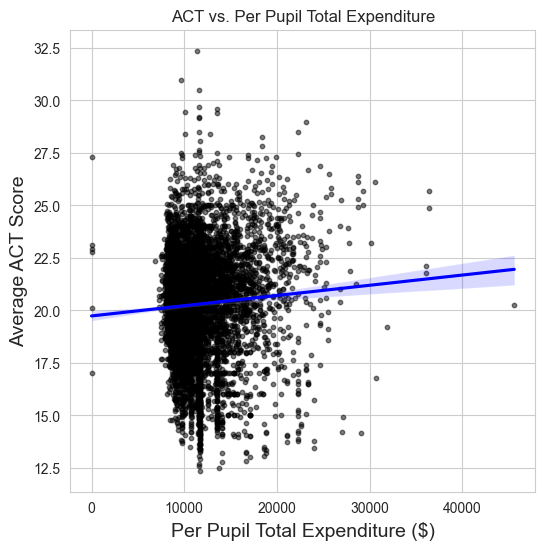

In [71]:
plt.figure(figsize=(6, 6))
sns.regplot(data=df,
            x='PerPupil_Total_Expenditure',
            y='average_act',
            color='blue',
            scatter_kws={'color': 'black', 's': 10, 'alpha': 0.5})

plt.xlabel('Per Pupil Total Expenditure ($)', fontsize=14)
plt.ylabel('Average ACT Score', fontsize=14)
plt.title('ACT vs. Per Pupil Total Expenditure')
plt.show()

## Per Instructor Salary vs. ACT Score
Higher instructor salaries may attract better teachers, potentially improving student performance overall.

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     256.9
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           7.74e-57
Time:                        10:40:30   Log-Likelihood:                -16774.
No. Observations:                7227   AIC:                         3.355e+04
Df Residuals:                    7225   BIC:                         3.357e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               18.5278 

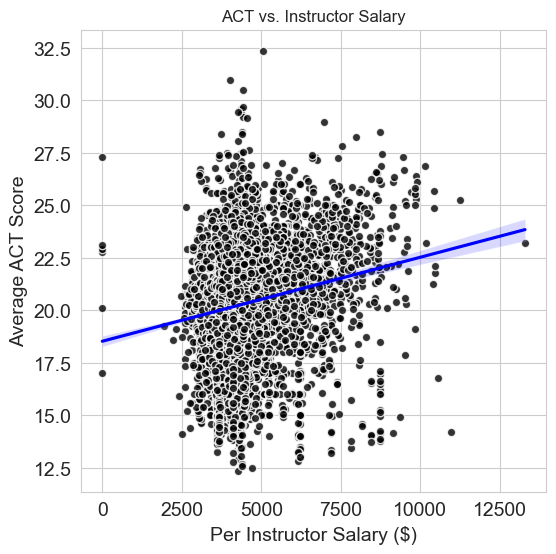

In [72]:
model_instr_salary = smf.ols(
    formula='average_act ~ PerInstructor_Salary',
    data=df
).fit()

print(model_instr_salary.summary())

plt.figure(figsize=(6, 6))
sns.regplot(data=df,
            x='PerInstructor_Salary',
            y='average_act',
            color='blue',
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

plt.xlabel('Per Instructor Salary ($)', fontsize=14)
plt.ylabel('Average ACT Score', fontsize=14)
plt.title('ACT vs. Instructor Salary')

# the tick labels
plt.tick_params(labelsize=14)

plt.show()


## Why Do They Look Similar?
Per Pupil Total Expediture and Per Instructor Salary are highly correlated (r = 0.89), which explains why their regression plots look extremly similar. Despite different scales, they capture overlapping patterns in ACT score.


In [73]:
df[['PerPupil_Total_Expenditure', 'PerInstructor_Salary']].corr()

,PerPupil_Total_Expenditure,PerInstructor_Salary
PerPupil_Total_Expenditure,1.000000,0.891867
PerInstructor_Salary,0.891867,1.000000


In [74]:
print(df['PerPupil_Total_Expenditure'].describe())
print(df['PerInstructor_Salary'].describe())

count     7227.000000
mean     11612.508423
std       3301.825052
min          0.000000
25%       9355.500000
50%      10685.000000
75%      12673.000000
max      45586.000000
Name: PerPupil_Total_Expenditure, dtype: float64
count     7227.000000
mean      4425.861912
std       1161.720302
min          0.000000
25%       3703.000000
50%       4174.000000
75%       4693.000000
max      13291.000000
Name: PerInstructor_Salary, dtype: float64


## Multiple Linear Regression
multiple regression model evaluates the combined impact of various predictors related to schoold fuding on ACT scores and identifies the most influential one

In [75]:
model = smf.ols(
    formula='average_act ~ PerPupil_Total_Expenditure + PerPupil_Salary_Expenditure + PerPupil_Benefits_Expenditure + PerInstructor_Salary + PerInstructor_Benefits + PerPupil_StudentSupport_Expenditure',
    data=df
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     162.8
Date:                Thu, 23 Oct 2025   Prob (F-statistic):          9.91e-195
Time:                        10:40:30   Log-Likelihood:                -16442.
No. Observations:                7227   AIC:                         3.290e+04
Df Residuals:                    7220   BIC:                         3.295e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [76]:
y_hat = model.predict()

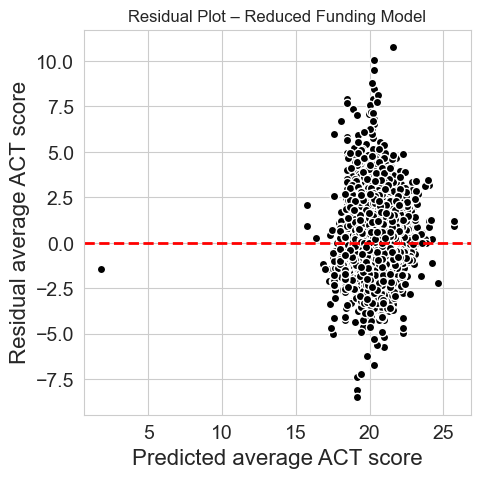

In [77]:
plt.figure(figsize=(5, 5))

plt.plot(y_hat, model_reduced.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)
plt.title('Residual Plot – Reduced Funding Model')
plt.show()

##### Use the iterative imputer to replace missing values in the columns corresponding to predictor variables in the analysis.